## 2. Audio Reconstruction
Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time 
(
t
)
 to amplitude 
(
A
)
, where 
t
 is the time point, and 
A
 is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction. [1.5 Mark]

> Imports and Data Loading Cell

In [ ]:
import numpy as np
import torch
import torchaudio
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load audio and sample rate
!wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav

from IPython.display import Audio
Audio('gt_bach.wav')
audio, sr = torchaudio.load('./gt_bach.wav')
audio = audio[0]  # Use the first channel if stereo
audio = audio.numpy()  # Convert to numpy for easier processing

# Normalize the audio between -1 and 1 (or as needed)
audio = (audio - np.min(audio)) / (np.max(audio) - np.min(audio))
audio = audio[-2 * sr:]

--2024-09-18 21:10:22--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.111.153, 185.199.108.153, 185.199.109.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: 'gt_bach.wav.6'

gt_bach.wav.6       100%[===================>]   1.17M  --.-KB/s    in 0.04s   

2024-09-18 21:10:22 (30.8 MB/s) - 'gt_bach.wav.6' saved [1232886/1232886]



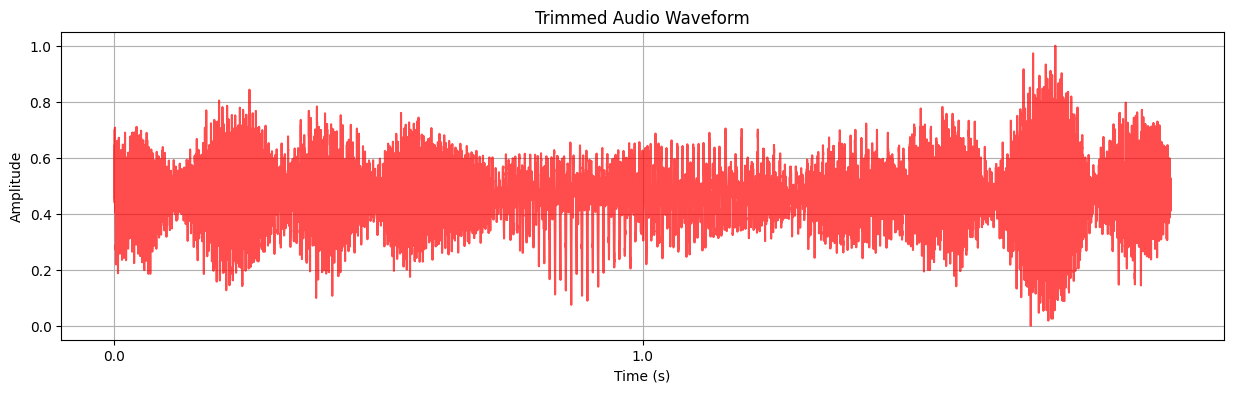

In [ ]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')
Audio(audio, rate = sr)

> Utility Functions (RMSE and PSNR) Cell

In [ ]:
# Function to compute RMSE
def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat) ** 2))

# Function to compute PSNR
def psnr(y, y_hat):
    rmse_value = rmse(y, y_hat)
    if rmse_value == 0:
        return np.inf
    else:
        return 20 * np.log10(1.0 / rmse_value)  # Assuming normalized audio between -1 and 1


> Random Fourier Features (RFF) Transformation Cell

In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

> ### Linear Regression Model Using sklearn Cell

In [ ]:
# Use sklearn's LinearRegression model
num_features = 5000
sigma = 0.008

X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

X_rff = create_rff_features(X, num_features, sigma)

# Train sklearn LinearRegression model
model = LinearRegression()
model.fit(X_rff.numpy(), audio)

# Predict using the trained model
SKleran_audio = model.predict(X_rff.numpy())
print("Predicted audio shape (sklearn LinearRegression):", SKleran_audio.shape)

# Calculate and print RMSE and PSNR
print(f"RMSE (sklearn): {rmse(audio, SKleran_audio)}")
print(f"PSNR (sklearn): {psnr(audio, SKleran_audio)}")


torch.Size([88200, 1])
tensor([[-100.0000],
        [ -99.9977],
        [ -99.9955],
        ...,
        [  99.9955],
        [  99.9977],
        [ 100.0000]])
Predicted audio shape (sklearn LinearRegression): (88200,)
RMSE (sklearn): 0.07225348055362701
PSNR (sklearn): 22.822824549607947


In [ ]:
import joblib

# Save model to a file
joblib.dump(model, 'model.pkl')

# Load model from the file
model = joblib.load('model.pkl')

import soundfile as sf

# Save the predicted audio to a .wav file
sf.write('pred_audio.wav', SKleran_audio, sr)

In [ ]:
Audio(audio, rate=sr)

In [ ]:
Audio(SKleran_audio, rate=sr)

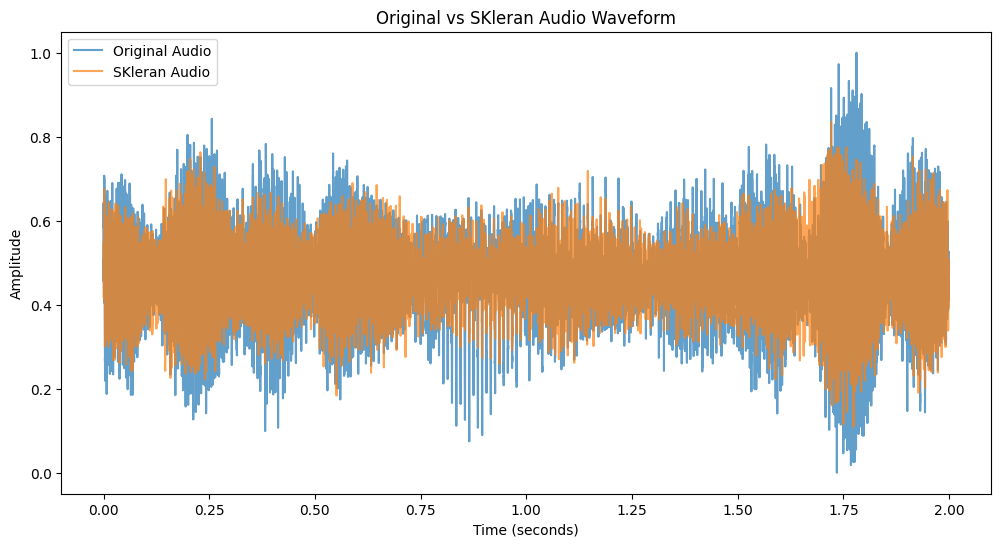

In [ ]:
import matplotlib.pyplot as plt

time_axis = np.linspace(0, len(audio) / sr, len(audio))


plt.figure(figsize=(12, 6))
plt.plot(time_axis, audio, label="Original Audio", alpha=0.7)
plt.plot(time_axis, SKleran_audio, label="SKleran Audio", alpha=0.7)
plt.title("Original vs SKleran Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


> ### Linear Model Class in PyTorch Cell  
> Used `mini-batch` gradient descent on MSE Loss using `ADAM` optimiser

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a Linear Model in PyTorch
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

def train_with_batches(model, X, Y, lr=0.005, epochs=1000, batch_size=2048):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_batches = len(X) // batch_size

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i in range(num_batches + 1):
            start = i * batch_size
            end = min((i + 1) * batch_size, len(X))
            
            # Create mini-batches
            X_batch = X[start:end]
            Y_batch = Y[start:end]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {running_loss / num_batches}")

            
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert RFF to PyTorch tensor
X_rff_torch = X_rff.float().to(device)
audio_Y_torch = torch.tensor(audio, dtype=torch.float32).to(device).unsqueeze(1)

# Initialize and train the model with mini-batches
net = LinearModel(X_rff_torch.shape[1], 1).to(device)
train_with_batches(net, X_rff_torch, audio_Y_torch, lr=0.005, epochs=500)

# Predict using the trained PyTorch model
torch_audio = net(X_rff_torch).detach().cpu().numpy()

# Calculate and print RMSE and PSNR for PyTorch model
print(f"RMSE (PyTorch): {rmse(audio, torch_audio.flatten())}")
print(f"PSNR (PyTorch): {psnr(audio, torch_audio.flatten())}")

# Play the reconstructed audio
Audio(torch_audio.flatten(), rate=sr)


Epoch 0, Loss: 0.14449600442204363
RMSE (PyTorch): 0.07820797711610794
PSNR (PyTorch): 22.13497894370891


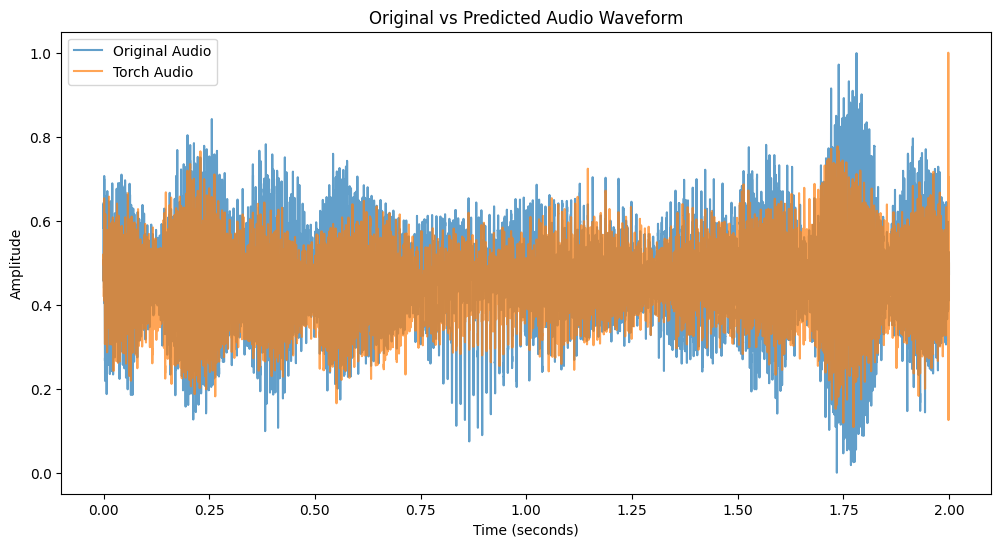

In [ ]:
import matplotlib.pyplot as plt

time_axis = np.linspace(0, len(audio) / sr, len(audio))


plt.figure(figsize=(12, 6))
plt.plot(time_axis, audio, label="Original Audio", alpha=0.7)
plt.plot(time_axis, torch_audio, label="Torch Audio", alpha=0.7)
plt.title("Original vs Predicted Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

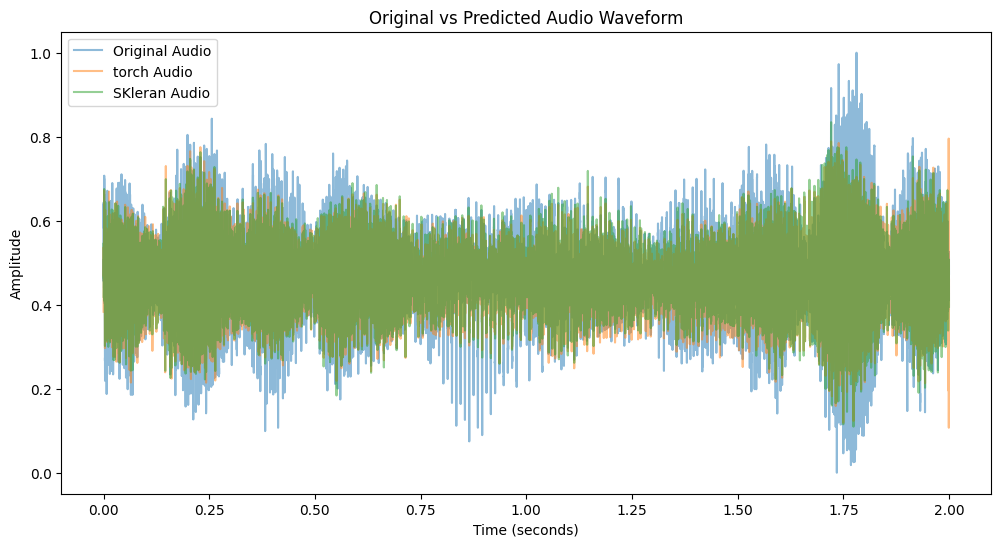

In [ ]:
import matplotlib.pyplot as plt

time_axis = np.linspace(0, len(audio) / sr, len(audio))


plt.figure(figsize=(12, 6))
plt.plot(time_axis, audio, label="Original Audio", alpha=0.5)
plt.plot(time_axis, reconstructed_audio, label="torch Audio", alpha=0.5)
plt.plot(time_axis, SKleran_audio, label="SKleran Audio", alpha=0.5)
plt.title("Original vs Predicted Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## The code given below used too much memory as i had to smaller batch size

In [ ]:
# Define a Linear Model in PyTorch
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

def train(model, X, Y, lr=0.005, epochs=1000):
    # Loss and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    



# Predict Using PyTorch Model and Calculate RMSE, PSNR Cell

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert RFF to PyTorch tensor
X_rff_torch = X_rff.float().to(device)
audio_Y_torch = torch.tensor(audio, dtype=torch.float32).to(device).unsqueeze(1)

# Initialize and train the model
net = LinearModel(X_rff_torch.shape[1], 1).to(device)
train(net, X_rff_torch, audio_Y_torch, lr=0.005, epochs=500)

# Predict using the trained PyTorch model
reconstructed_audio = net(X_rff_torch).detach().cpu().numpy()

# Calculate and print RMSE and PSNR for PyTorch model
print(f"RMSE (PyTorch): {rmse(audio, reconstructed_audio)}")
print(f"PSNR (PyTorch): {psnr(audio, reconstructed_audio)}")

Audio(reconstructed_audio, rate = sr)


Epoch 0, Loss: 0.22133399546146393


In [ ]:
Audio(audio, rate=sr)

In [ ]:
Audio(reconstructed_audio, rate=sr)